## 📦 Importing required libraries

In [14]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot
import cufflinks as cf
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot


## 📂 Loading COVID-19 dataset


In [2]:
df = pd.read_csv('epidemiology.csv')
df.head()

,date,location_key,new_confirmed,new_deceased,new_recovered,new_tested,cumulative_confirmed,cumulative_deceased,cumulative_recovered,cumulative_tested
0,2020-01-01,AD,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN
1,2020-01-02,AD,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN
2,2020-01-03,AD,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN
3,2020-01-04,AD,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN
4,2020-01-05,AD,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN


## Describe Data

In [5]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12525825 entries, 0 to 12525824
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   date                  object 
 1   location_key          object 
 2   new_confirmed         float64
 3   new_deceased          float64
 4   new_recovered         float64
 5   new_tested            float64
 6   cumulative_confirmed  float64
 7   cumulative_deceased   float64
 8   cumulative_recovered  float64
 9   cumulative_tested     float64
dtypes: float64(8), object(2)
memory usage: 955.6+ MB


,new_confirmed,new_deceased,new_recovered,new_tested,cumulative_confirmed,cumulative_deceased,cumulative_recovered,cumulative_tested
count,1.247580e+07,1.166714e+07,3.980462e+06,3.194489e+06,1.232704e+07,1.147482e+07,3.991157e+06,3.012920e+06
mean,1.111905e+02,1.274817e+00,2.104549e+02,2.509508e+03,3.539969e+04,5.874310e+02,6.655680e+04,9.057159e+05
std,1.165983e+04,8.808127e+01,1.898989e+04,2.955847e+05,6.135014e+05,9.228857e+03,1.572899e+06,1.518347e+07
min,-5.045418e+06,-6.381100e+04,-1.001683e+07,-3.541552e+08,0.000000e+00,0.000000e+00,-3.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.020000e+02,3.000000e+00,0.000000e+00,3.460000e+02
50%,1.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,1.034000e+03,1.800000e+01,7.000000e+00,1.890000e+03
75%,1.100000e+01,0.000000e+00,5.000000e+00,5.200000e+01,5.002000e+03,8.100000e+01,3.099000e+03,1.508900e+04
max,5.047094e+06,6.383000e+04,9.967355e+06,3.541856e+08,9.244050e+07,1.005195e+06,2.345841e+08,9.214000e+09


In [20]:
df['date'] = pd.to_datetime(df['date'])
oldest_date = df['date'].min().date()
latest_date = df['date'].max().date()

print("📉 Oldest date:", oldest_date)
print("📈 Latest date:", latest_date)


📉 Oldest date: 2019-12-31
📈 Latest date: 2022-12-30


## 🧹 Cleaning COVID-19 dataset

In [25]:
# Drop rows with missing location_key or date
df_cleaned = df.dropna(subset=['location_key', 'date']).copy()

# Identify France's cumulative recovery data
france_mask = df_cleaned['location_key'] == 'FR'

# Convert France's cumulative values to daily differences
df_cleaned.loc[france_mask, 'new_recovered'] = df_cleaned.loc[france_mask, 'new_recovered'].diff()

# Convert date to datetime
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'], errors='coerce')
df_cleaned = df_cleaned.dropna(subset=['date'])

# Define columns to clean
cols_to_clean = ['new_confirmed', 'new_deceased', 'new_recovered','new_tested']

# Convert to numeric and clean values
for col in cols_to_clean:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce').fillna(0)
    
# Drop duplicate date entries per location
df_cleaned = df_cleaned.sort_values(by=['location_key', 'date'])
df_cleaned = df_cleaned.drop_duplicates(subset=['location_key', 'date'], keep='first')


# Recalculate cumulative columns
for col in cols_to_clean:
    cum_col = 'cumulative_' + col.split('_')[1]
    df_cleaned[cum_col] = df_cleaned.groupby('location_key')[col].cumsum()
    
# Filtering Irregular values
df_cleaned.loc[(df_cleaned['location_key'] == 'AU') & (df_cleaned['date'] == '2022-09-11'), 'new_recovered'] = 0

In [26]:
df_country = df_cleaned[df_cleaned['location_key'].str.len() == 2]
df_country

,date,location_key,new_confirmed,new_deceased,new_recovered,new_tested,cumulative_confirmed,cumulative_deceased,cumulative_recovered,cumulative_tested
0,2020-01-01,AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-02,AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-03,AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-04,AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-05,AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
12525820,2022-09-09,ZW,11.0,0.0,0.0,0.0,256870.0,5596.0,0.0,1869683.0
12525821,2022-09-10,ZW,18.0,0.0,0.0,0.0,256888.0,5596.0,0.0,1869683.0
12525822,2022-09-11,ZW,0.0,0.0,0.0,0.0,256888.0,5596.0,0.0,1869683.0
12525823,2022-09-12,ZW,51.0,0.0,0.0,0.0,256939.0,5596.0,0.0,1869683.0


In [101]:
df_country.to_excel('df_cleaned_fr.xlsx',index=False)

## Slicing Data

In [162]:
# Sort by location_key alphabetically
sorted_df = df.dropna(subset='location_key').sort_values(by='location_key')
a_entries = sorted_df[sorted_df['location_key'].str.startswith('F')]


# Export to Excel
a_entries.to_excel("df_F.xlsx", index=False)


6955155
7051292


## 🧮 Calculate death and survival rates

In [27]:
import pycountry

# Step 1: Convert ISO-2 to ISO-3
def iso2_to_name(code):
    try:
        return pycountry.countries.get(alpha_2=code).name
    except:
        return None

df_country.loc[:, 'country'] = df_country['location_key'].str.split('_').str[0].apply(iso2_to_name)

In [51]:
# Step 1: Filter out rows with zero confirmed cases
df_rate = df_country[(df_country['new_confirmed'] > 0) & (df_country['cumulative_confirmed']>0)].copy()

# Step 2: Calculate death and survival rates
df_rate['Death Rate'] = df_rate['new_deceased'] / df_rate['new_confirmed']
df_rate['Recovery Rate'] = df_rate['new_recovered'] / df_rate['new_confirmed']

# Step 3: Cumulative totals from full dataset (not filtered)
total_deaths = df_rate['new_deceased'].sum()
total_recovered = df_rate['new_recovered'].sum()

# Step 4: Print results
print("📊 Cumulative Deaths:", total_deaths)
print("📊 Cumulative Recovered:", total_recovered)
print("📉 Average Death Rate:", round(df_rate['Death Rate'].mean() * 100, 2), "%")
print("📈 Average Recovery Rate:", round(df_rate['Recovery Rate'].mean() * 100, 2), "%")


📊 Cumulative Deaths: 6415379.0
📊 Cumulative Recovered: 103217413.0
📉 Average Death Rate: 5.8 %
📈 Average Recovery Rate: 10.19 %


In [52]:
# Step 1: Group and aggregate
deaths = df_rate.groupby('location_key')['cumulative_deceased'].max()
cases = df_rate.groupby('location_key')['cumulative_confirmed'].max()

# Step 2: Combine into a new DataFrame
df_death_rate = pd.DataFrame({
    'Total Deaths': deaths,
    'Total Cases': cases
})

# Step 3: Calculate death rate
df_death_rate['Total Death Rate'] = df_death_rate['Total Deaths'] / df_death_rate['Total Cases']

# Step 4: Clean and sort
df_death_rate = df_death_rate[df_death_rate['Total Cases'] > 0].dropna()
df_death_rate = df_death_rate.sort_values('Total Death Rate', ascending=False)



In [65]:
top10 = df_death_rate.sort_values('Total Death Rate', ascending=False).head(10).reset_index()
top10_case = df_death_rate.sort_values('Total Cases', ascending=False).head(10).reset_index()
top10

,location_key,Total Deaths,Total Cases,Total Death Rate
0,YE,2155.0,11932.0,0.180607
1,CA,48429.0,426676.0,0.113503
2,SD,4961.0,63275.0,0.078404
3,SY,3163.0,57197.0,0.055300
4,PE,216418.0,4143293.0,0.052233
5,SO,1361.0,27197.0,0.050042
6,EG,24796.0,515348.0,0.048115
7,MX,328010.0,7037463.0,0.046609
8,BA,16104.0,397602.0,0.040503
9,AF,7791.0,196663.0,0.039616


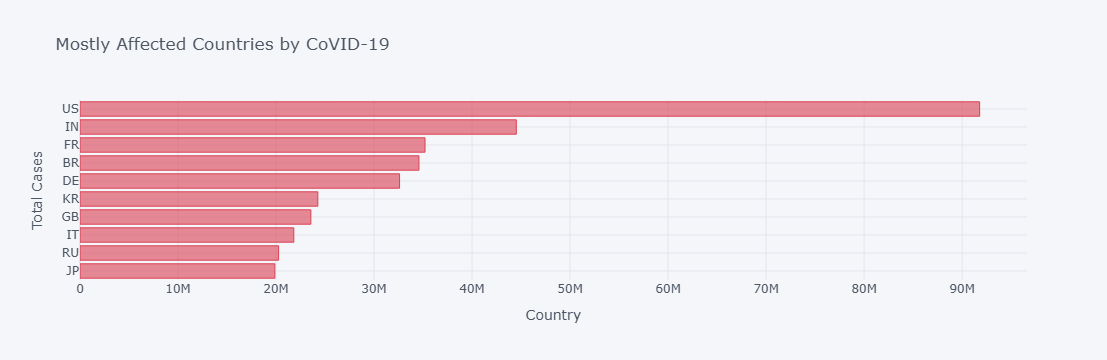

In [68]:

cf.go_offline()
top10_case[::-1].iplot(kind='bar',
                  x='location_key',
                  y='Total Cases',
                  orientation='h',
                  title='Mostly Affected Countries by CoVID-19',
                  xTitle='Country',
                  yTitle='Total Cases',
                  sortbars=False,
                  color='Red'
                 )

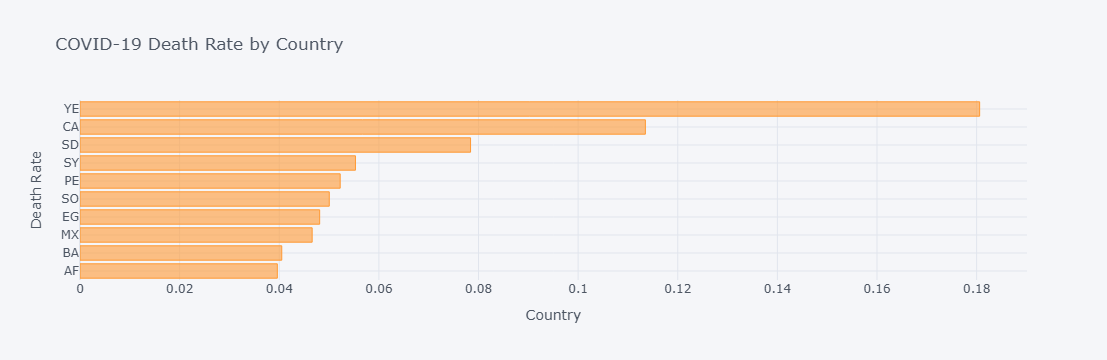

In [61]:

cf.go_offline()
top10[::-1].iplot(kind='bar',
                  x='location_key',
                  y='Total Death Rate',
                  orientation='h',
                  title='COVID-19 Death Rate by Country',
                  xTitle='Country',
                  yTitle='Death Rate',
                  sortbars=True
                 )

## 🌍Mapping COVID-19 Mortality and Survival by Country

In [97]:
import pycountry

# Step 1: Convert ISO-2 to ISO-3
def iso2_to_name(code):
    try:
        return pycountry.countries.get(alpha_2=code).name
    except:
        return None

df_country.loc[:, 'country'] = df_country['location_key'].str.split('_').str[0].apply(iso2_to_name)

C:\Users\BHUIYAN GADGET\AppData\Local\Temp\ipykernel_3808\2293651440.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [69]:
# Grouping by location_key and sum daily deaths and survivals
total_deaths_by_location = df_country.groupby('country')['new_deceased'].sum()
total_recovered_by_location = df_country.groupby('country')['new_recovered'].sum()

# Filtering locations with total deaths or survivals > 0
filtered_deaths = total_deaths_by_location[total_deaths_by_location > 0]
filtered_recovered = total_recovered_by_location[total_recovered_by_location > 0]

# Converting Series to DataFrame
total_deaths_df = filtered_deaths.reset_index()
total_recovered_df = filtered_recovered.reset_index()

# Renaming columns for clarity
total_deaths_df.columns = ['location_key', 'total_deaths']
total_recovered_df.columns = ['location_key', 'total_recovered']

# Display result
total_deaths_df
#total_recovered_df


,location_key,total_deaths
0,Afghanistan,7791.0
1,Albania,3586.0
2,Algeria,6879.0
3,American Samoa,34.0
4,Andorra,155.0
...,...,...
216,"Virgin Islands, U.S.",123.0
217,Wallis and Futuna,7.0
218,Yemen,2155.0
219,Zambia,4017.0


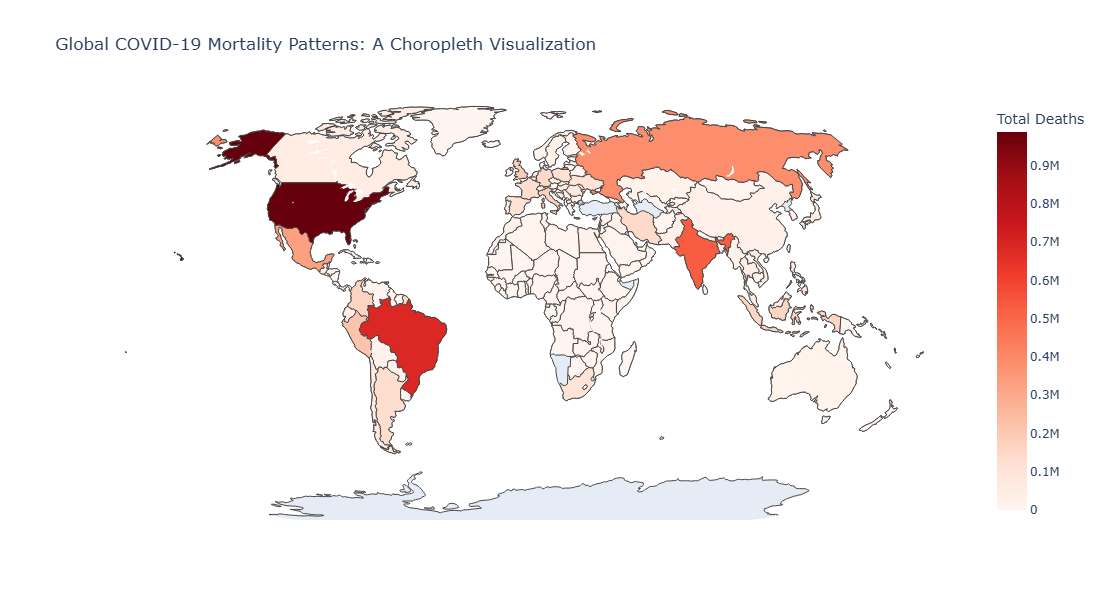

In [89]:
# 🌍 Prepare choropleth data on mortality
chorodata = go.Choropleth(
    locations=total_deaths_df['location_key'],
    locationmode='country names',
    z=total_deaths_df['total_deaths'],
    colorscale='Reds',
    colorbar_title='Total Deaths',
    #text=total_deaths_df['total_deaths']
)

# 🗺️ Define layout
layout = go.Layout(
    title='Global COVID-19 Mortality Patterns: A Choropleth Visualization',
    width=1000,
    height=600,
    geo=dict(
        showframe=False,
        projection=dict(type='natural earth')
    )
)

# 🖼️ Create and display the figure
fig = go.Figure(data=[chorodata], layout=layout)
iplot(fig)

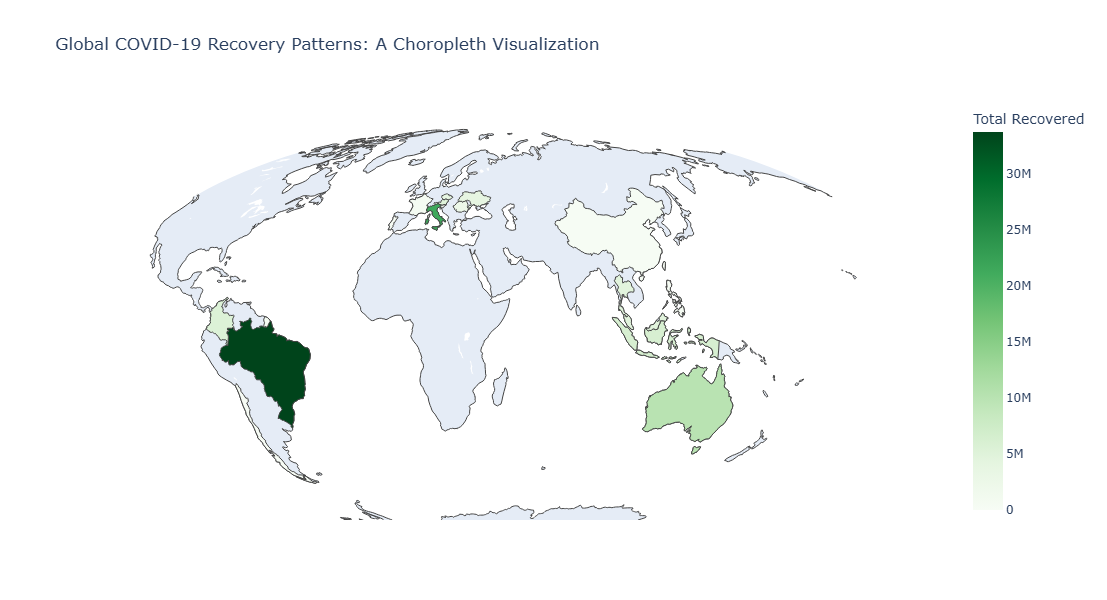

In [103]:
# 🌍 Prepare choropleth data on recovered
chorodata = go.Choropleth(
    locations=total_recovered_df['location_key'],
    locationmode='country names',
    z=total_recovered_df['total_recovered'],
    colorscale='Greens',
    colorbar_title='Total Recovered',
)  

# 🗺️ Define layout
layout = go.Layout(
    title='Global COVID-19 Recovery Patterns: A Choropleth Visualization',
    width=1000,
    height=600,
    geo=dict(
        showframe=False,
        projection=dict(type='mollweide')
    )
)

# 🖼️ Create and display the figure
fig = go.Figure(data=[chorodata], layout=layout)
iplot(fig)